Step 1: Get data

In [1]:
import pandas as pd

# Load the CSV file
users = pd.read_csv('rating.csv')
animes = pd.read_csv('anime.csv')
print(users.head())
print(animes.head())


   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262 

In [2]:
from sklearn.model_selection import train_test_split
import pickle

In [3]:
# just crop data to be first n
users = users[:500000]
train_users, test_users = train_test_split(users, test_size=0.1)

In [4]:
from collections import defaultdict

# get some useful info from users
allUsers = set()
allAnime = set()
usersPerAnime = defaultdict(set) # Maps an anime to the user who rated it
animePerUser = defaultdict(set) # Maps a user to the anime that they rated
reviewsPerUser = defaultdict(list)
reviewsPerAnime = defaultdict(list)
ratingDict = {} # To retrieve a rating for a specific user/item pair


# item = book in this case
for _, d in users.iterrows():
    user = d['user_id']
    allUsers.add(user)
    anime = d['anime_id']
    allAnime.add(anime)
    usersPerAnime[anime].add(user)
    animePerUser[user].add(anime)
    reviewsPerAnime[anime].append(d)
    reviewsPerUser[user].append(d)
    ratingDict[(user,anime)] = d['rating']


In [5]:
# Compute popularity scores
popularity_dict=defaultdict(float) # score from 0-1 about how popular it is, 1 being the max. 

max_users = max(len(users) for users in usersPerAnime.values()) if usersPerAnime else 1
for anime, users in usersPerAnime.items():
    popularity_dict[anime] = len(users) / max_users  # Normalize popularity score


In [6]:
# print(len(animePerUser))
print(len(popularity_dict))

7145


In [7]:
# # Load from pickle files
# with open('train_users.pkl', 'rb') as f:
#     train_users = pickle.load(f)
# 
# with open('test_users.pkl', 'rb') as f:
#     test_users = pickle.load(f)

In [8]:

print(f"train set : {len(train_users)}, test set people: {len(test_users)}")
print(test_users.head())

train set : 450000, test set people: 50000
        user_id  anime_id  rating
181936     1831     11741       9
187377     1873     10790       8
406054     4177      6791       6
360696     3668     18679       4
465891     4796     19221       6


In [9]:
# # Save train and test dataframes
# with open('train_users.pkl', 'wb') as f:
#     pickle.dump(train_users, f)
# 
# with open('test_users.pkl', 'wb') as f:
#     pickle.dump(test_users, f)

In [10]:
# what is the rating scale? 
# print('max rating is ', max(train_users['rating'])) # its 10
# print('min rating is ', min(train_users['rating'])) # its -1

Now create baseline model for recommendation

In [11]:
from surprise import Dataset, Reader, SVDpp
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
from itertools import combinations
from scipy.spatial.distance import cosine

In [12]:
reader = Reader(rating_scale=(-1, 10))  # Assuming ratings from 1 to 5
train_data = Dataset.load_from_df(train_users, reader)  # Assuming ratings_df is your ratings dataframe
trainset = train_data.build_full_trainset()
test_data = Dataset.load_from_df(test_users, reader)
svdpp = SVDpp(n_factors=3, n_epochs=20, lr_all=0.007, reg_all=0.02, verbose=True)


In [13]:
svdpp.fit(trainset)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19


In [14]:
from surprise.model_selection import KFold

kf = KFold(random_state=0)  # folds will be the same for all algorithms.
cross_validate(svdpp, test_data, ["rmse","mae"],kf)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8


{'test_rmse': array([2.58501747, 2.5425379 , 2.55719575, 2.51677231, 2.54850444]),
 'test_mae': array([1.77410985, 1.73042341, 1.7396783 , 1.73710074, 1.7396116 ]),
 'fit_time': (0.38126611709594727,
  0.3870208263397217,
  0.3954811096191406,
  0.38018107414245605,
  0.38246870040893555),
 'test_time': (0.19228696823120117,
  0.18761825561523438,
  0.18885207176208496,
  0.19255781173706055,
  0.24896001815795898)}

Now we need to test diversity

In [94]:
#precompute some useful info

# Global caches for performance
user_similarity_cache = {}
anime_genres = {}
anime_popularity = {}
max_popularity = 1
popularity_threshold = 0

def initialize_caches(anime_df):
    """Initialize global caches for faster lookups."""
    global anime_genres, anime_popularity, max_popularity, popularity_threshold
    
    print('initializing caches')
    
    # Pre-compute genre sets for each anime
    for i, row in anime_df.iterrows():
        if i % 100 == 0:
            print(f'at no. {i}. {i/len(anime_df)*100}% complete')
        anime_id = int(row['anime_id'])
        genre_str = row.get('genre', '')
        anime_genres[anime_id] = set(genre_str.split(', ')) if pd.notna(genre_str) else set()
    
    # Pre-compute popularity scores
    anime_popularity = {int(row['anime_id']): row.get('members', 0) for _, row in anime_df.iterrows()}
    max_popularity = max(anime_popularity.values()) if anime_popularity else 1
    
    # Pre-compute the percentile popularity threshold
    popularity_threshold = np.percentile(list(anime_popularity.values()), 90) if anime_popularity else 0

In [158]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from itertools import combinations

def jaccard_similarity(set1, set2):
    """Compute Jaccard similarity between two sets."""
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

def get_similar_users(user_id, k=10):
    """Find k most similar users with caching."""
    if user_id in user_similarity_cache:
        return user_similarity_cache[user_id][:k]
    
    if user_id not in animePerUser:
        return []
    
    user_watched = animePerUser[user_id]
    similarities = {}

    for other_user, other_watched in animePerUser.items():
        if other_user == user_id:
            continue
        similarities[other_user] = jaccard_similarity(user_watched, other_watched)
    
    result = [uid for uid, _ in sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:k]]
    user_similarity_cache[user_id] = result
    return result

def enhanced_genre_similarity(genres1, genres2):
    """
    Calculate enhanced genre similarity that more heavily penalizes overlaps.
    Returns a similarity score where 0 = completely diverse, 1 = identical
    """
    if not genres1 and not genres2:
        return 0.0
    
    intersection = len(genres1.intersection(genres2))
    union = len(genres1.union(genres2))
    
    if union == 0:
        return 0.0
    
    # Basic Jaccard similarity
    jaccard = intersection / union
    
    # Apply exponential penalty to amplify similarity scores
    # This makes medium similarities much higher, heavily penalizing any overlap
    # Values closer to 0 remain low, values >0.3 get boosted significantly
    if jaccard > 0:
        enhanced_sim = jaccard ** 0.5  # Square root increases penalty for small overlaps
    else:
        enhanced_sim = 0
        
    return enhanced_sim

def old_calculate_diversity(anime_ids, svdpp):
    """Calculate diversity with proper latent factor diversity from SVD++."""
    # Convert all IDs to integers
    anime_ids = [int(aid) for aid in anime_ids]
    
    # Extract genre sets and popularity scores
    genre_sets = [anime_genres.get(aid, set()) for aid in anime_ids]
    popularity_scores = [anime_popularity.get(aid, 0) for aid in anime_ids]
    
    # Calculate genre similarities
    genre_similarities = []
    for i, j in combinations(range(len(genre_sets)), 2):
        if genre_sets[i] or genre_sets[j]:  # Skip empty sets
            genre_similarities.append(jaccard_similarity(genre_sets[i], genre_sets[j]))
    
    # Calculate genre diversity (avoid division by zero)
    genre_diversity = 1 - (sum(genre_similarities) / len(genre_similarities)) if genre_similarities else 1
    
    # Calculate latent diversity using SVD++ item factors
    latent_similarities = []
    for i, j in combinations(range(len(anime_ids)), 2):
        # Convert raw anime IDs to inner IDs used by SVD++
        try:
            inner_id_i = svdpp.trainset.to_inner_iid(anime_ids[i])
            inner_id_j = svdpp.trainset.to_inner_iid(anime_ids[j])
            
            # Get item factors from SVD++ using inner IDs
            item_i_factors = svdpp.qi[inner_id_i]
            item_j_factors = svdpp.qi[inner_id_j]
            
            # Calculate cosine similarity between factor vectors
            sim = cosine_similarity([item_i_factors], [item_j_factors])[0][0]
            latent_similarities.append(sim)
        except ValueError:
            # Handle cases where anime_id isn't in the trainset
            if anime_ids[i] not in svdpp.trainset.all_items():
                print(f"Missing latent factors for anime_id: {anime_ids[i]}")
            if anime_ids[j] not in svdpp.trainset.all_items():
                print(f"Missing latent factors for anime_id: {anime_ids[j]}")
    
    # Calculate latent diversity (avoid division by zero)
    latent_diversity = 1 - (sum(latent_similarities) / (len(latent_similarities) + 1e-8))
    # normalize to be within [0-1]
    latent_diversity = max(0, min(latent_diversity, 1))
    
    
    # Calculate long tail penalty
    avg_popularity = sum(popularity_scores) / (len(popularity_scores) * max_popularity) if popularity_scores and max_popularity > 0 else 0.5
    long_tail_penalty = 1 - avg_popularity
    
    # Weighted combination
    diversity_score = (0.4 * genre_diversity) + (0.4 * latent_diversity) + (0.2 * long_tail_penalty)
    
    return diversity_score, genre_diversity, latent_diversity, long_tail_penalty

def calculate_diversity(anime_ids, svdpp):
    """Calculate diversity with improved genre similarity and popularity adjustment."""
    global popularity_threshold
    
    # Convert all IDs to integers
    anime_ids = [int(aid) for aid in anime_ids]

    # Extract genre sets and popularity scores
    genre_sets = [anime_genres.get(aid, set()) for aid in anime_ids]
    popularity_scores = [anime_popularity.get(aid, 0) for aid in anime_ids]
    
    # Calculate genre similarities with enhanced penalty
    genre_similarities = []
    for i, j in combinations(range(len(genre_sets)), 2):
        if genre_sets[i] or genre_sets[j]:  # Skip empty sets
            # Use enhanced similarity function instead of basic Jaccard
            sim = enhanced_genre_similarity(genre_sets[i], genre_sets[j])
            
            genre_similarities.append(1-sim)# we want diversity scores
    
    # Calculate genre diversity (avoid division by zero)
    genre_diversity = 1 - (sum(genre_similarities) / len(genre_similarities)) if genre_similarities else 1

    # Calculate latent diversity using SVD++ item factors
    latent_similarities = []
    for i, j in combinations(range(len(anime_ids)), 2):
        try:
            # Convert raw anime IDs to inner IDs used by SVD++
            inner_id_i = svdpp.trainset.to_inner_iid(anime_ids[i])
            inner_id_j = svdpp.trainset.to_inner_iid(anime_ids[j])

            # Get item factors from SVD++
            item_i_factors = svdpp.qi[inner_id_i]
            item_j_factors = svdpp.qi[inner_id_j]

            # Alternative similarity measure: Euclidean distance (normalized)
            dist = np.linalg.norm(item_i_factors - item_j_factors)
            max_dist = np.sqrt(len(item_i_factors))  # Maximum possible distance
            sim = 1-(dist / (max_dist*(5/4)))

            latent_similarities.append(sim)
        
        except ValueError:
            # Handle cases where anime_id isn't in the trainset
            print(f"Missing latent factors for anime_id: {anime_ids[i] if anime_ids[i] not in svdpp.trainset.all_items() else anime_ids[j]}")

    # Calculate latent diversity (avoid division by zero)
    latent_diversity = 1-(sum(latent_similarities) / (len(latent_similarities) + 1e-8))
    latent_diversity = max(0, min(latent_diversity, 1))  # Normalize to [0, 1]

    # Calculate long tail penalty using the pre-computed threshold
    n = len(anime_ids)
    long_tail_diversity = 0

    for aid in anime_ids:
        if anime_popularity.get(aid, 0) >= popularity_threshold:
            long_tail_diversity += 1 / (n)

    # Normalize the long tail penalty to [0, 1]
    long_tail_diversity = 1-max(0, min(long_tail_diversity, 1))
    

    # Weighted combination
    diversity_score = (0.4 * genre_diversity) + (0.4 * latent_diversity) + (0.2 * long_tail_diversity)

    return diversity_score, genre_diversity, latent_diversity, long_tail_diversity

def get_candidate_anime(similar_users):
    """Get anime watched by similar users."""
    if not similar_users:
        return []
    
    candidate_anime = set()
    for user in similar_users:
        if user in animePerUser:
            candidate_anime.update(animePerUser[user])
    
    return list(candidate_anime)

def get_predictions_batch(uid, candidate_anime, svdpp):
    """Get predictions for multiple anime IDs at once."""
    return [(iid, svdpp.predict(uid, int(iid)).est) for iid in candidate_anime]

def get_recommendations_with_diversity(test_users, svdpp, anime_df, n=5):
    """Get recommendations with diversity metrics and progress tracking."""
    # Initialize caches if not already done
    if not anime_genres:
        initialize_caches(anime_df)
    
    # Results arrays
    diversity_scores = []
    genre_diversity_scores = []
    latent_diversity_scores = []
    long_tail_penalty_scores = []
    
    # Implementation of predictions list: maps users to recommended anime
    predictions = []
    
    total_users = len(test_users)
    print(f"Processing {total_users} users...")
    
    # Process each user
    for i, (_, u) in enumerate(test_users.iterrows()):
        uid = int(u["user_id"])
        
        # Print progress every 10 users or at key percentages
        if i % 10 == 0 or i / total_users in [0.25, 0.5, 0.75, 0.99]:
            percentage = (i / total_users) * 100
            print(f"Progress: {percentage:.1f}% ({i}/{total_users} users processed)")
        
        # Get similar users and candidate anime
        similar_users = get_similar_users(uid, k=10)
        candidate_anime = get_candidate_anime(similar_users)
        
        if not candidate_anime:
            print(f"User {uid}: No candidate anime found, skipping")
            continue
        
        # Get predictions for candidate anime
        prediction_results = get_predictions_batch(uid, candidate_anime, svdpp)
        
        # Get top N recommendations
        top_n_anime = [iid for iid, _ in sorted(prediction_results, key=lambda x: x[1], reverse=True)[:n]]
        
        # Add to predictions list
        predictions.append({uid: top_n_anime})
        
        # Calculate diversity scores
        scores = calculate_diversity(top_n_anime, svdpp)
        
        # Store results
        diversity_scores.append(scores[0])
        genre_diversity_scores.append(scores[1])
        latent_diversity_scores.append(scores[2])
        long_tail_penalty_scores.append(scores[3])
    
    print(f"Completed processing all {total_users} users")
    
    # Calculate average metrics
    avg_diversity = sum(diversity_scores) / len(diversity_scores) if diversity_scores else 0
    print(f"Average diversity score: {avg_diversity:.4f}")
    
    return diversity_scores, genre_diversity_scores, latent_diversity_scores, long_tail_penalty_scores, predictions

In [16]:
# filter test_users to be unique users. 
test_users = test_users.drop_duplicates(subset="user_id")
print(len(test_users))

4404


In [17]:
# Get all anime IDs that exist in your dataset
all_anime_ids = set(test_users["anime_id"].tolist())

# Get anime IDs that exist in the SVD++ model
# For arrays, we need to check the internal raw_iid mapping
model_anime_ids = set(svdpp.trainset._raw2inner_id_items.keys())

# Find missing anime IDs
missing_anime = list(all_anime_ids - model_anime_ids)
print(f"Missing anime no.: {len(missing_anime)}")

Missing anime no.: 17


In [105]:
# Run recommendations and calculate diversity score
agg_scores, genre_scores, latent_scores, penalty_scores, predictions = get_recommendations_with_diversity(test_users[:100], svdpp, animes, n=20)

Processing 100 users...
Progress: 0.0% (0/100 users processed)
Progress: 10.0% (10/100 users processed)
Progress: 20.0% (20/100 users processed)
Progress: 25.0% (25/100 users processed)
Progress: 30.0% (30/100 users processed)
Progress: 40.0% (40/100 users processed)
Progress: 50.0% (50/100 users processed)
Progress: 60.0% (60/100 users processed)
Progress: 70.0% (70/100 users processed)
Progress: 75.0% (75/100 users processed)
Progress: 80.0% (80/100 users processed)
Progress: 90.0% (90/100 users processed)
Progress: 99.0% (99/100 users processed)
Completed processing all 100 users
Average diversity score: 0.1277


In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [85]:
def plot_diversity_scores(diversity_scores, genre_scores, latent_scores, penalty_scores, user_ids=None):
    """
    Plot diversity metrics across multiple users or recommendation sets.
    
    Args:
        diversity_scores: List of aggregate diversity scores
        genre_scores: List of genre diversity scores
        latent_scores: List of latent diversity scores
        penalty_scores: List of popularity penalty scores
        user_ids: Optional list of user IDs or labels (defaults to indices)
    """
    # Create x-axis labels (user IDs or indices)
    x_labels = user_ids if user_ids else range(len(diversity_scores))
    x_pos = np.arange(len(x_labels))
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot each metric as a separate line
    plt.plot(x_pos, diversity_scores, 'b-', label='Aggregate Diversity', linewidth=2, marker='o')
    plt.plot(x_pos, genre_scores, 'g-', label='Genre Diversity', linewidth=2, marker='s')
    plt.plot(x_pos, latent_scores, 'r-', label='Latent Diversity', linewidth=2, marker='^')
    plt.plot(x_pos, penalty_scores, 'y-', label='Popularity Penalty', linewidth=2, marker='x')
    
    # Add statistics
    avg_div = sum(diversity_scores) / len(diversity_scores)
    plt.axhline(y=avg_div, color='b', linestyle='--', alpha=0.7, 
                label=f'Avg Aggregate: {avg_div:.2f}')
    
    # Configure plot
    plt.xlabel('User ID' if user_ids else 'User Index')
    plt.ylabel('Diversity Score')
    plt.title('Recommendation Diversity Metrics by User')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Handle x-axis ticks for readability
    if len(x_labels) > 10:
        plt.xticks(x_pos[::5], x_labels[::5])  # Show every 5th label
    else:
        plt.xticks(x_pos, x_labels)
        
    plt.tight_layout()
    plt.savefig('svd_diversity_scores.png')
    plt.show()
    

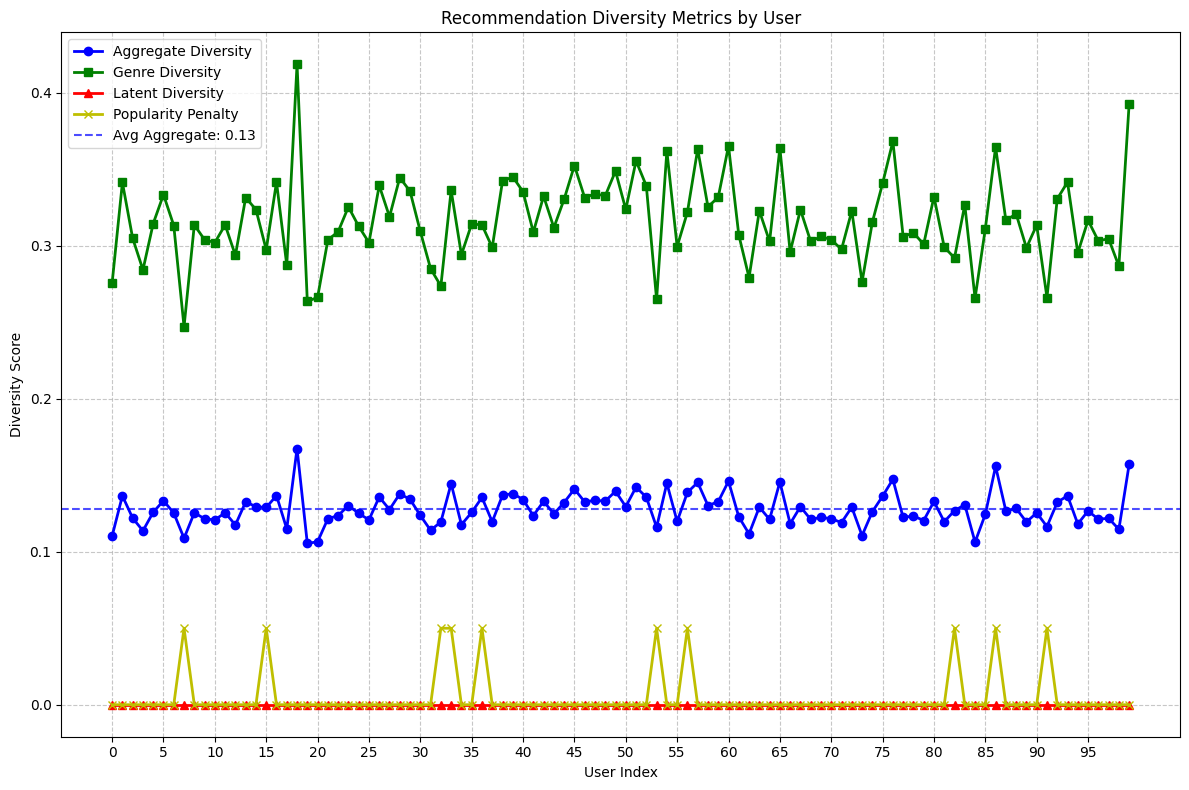

In [106]:
plot_diversity_scores(agg_scores,genre_scores,latent_scores,penalty_scores)

In [56]:
print(predictions[:5])

[{1831: [5114, 19, 6114, 9253, 5205, 877, 16498, 32, 1535, 245, 1575, 4177, 13125, 2001, 10162, 6594, 2904, 11771, 1, 934]}, {1873: [9969, 918, 9253, 11061, 31240, 5114, 16498, 877, 28977, 16662, 245, 1535, 18195, 467, 12365, 4177, 32, 2904, 1, 136]}, {4177: [9969, 9253, 6114, 11061, 31240, 21329, 1, 877, 5205, 1535, 2904, 16498, 12711, 245, 467, 18195, 12365, 136, 28891, 32]}, {3668: [4059, 30276, 11061, 9253, 199, 5081, 19, 1604, 226, 6114, 2966, 4280, 2251, 4106, 14713, 7724, 11633, 223, 4181, 10800]}, {4796: [5114, 1575, 2001, 1535, 1, 918, 11757, 16498, 14719, 2167, 30, 19815, 9756, 9989, 2904, 31240, 32, 16894, 23283, 2025]}]


Now, we implement a custom recommender

Step 1: create clusters for anime based on full metadata
consider one hot encoding genres first? 

Revise the data to prep for clustering

In [23]:
cluster_df = animes.copy()

# Handle missing or NaN values by replacing them with an empty string
cluster_df['genre'] = cluster_df['genre'].fillna('')

# Split the 'genre' column by commas and remove extra spaces
genre_list = cluster_df['genre'].str.split(',').apply(lambda x: [genre.strip() for genre in x])

# Get a list of all unique genres
all_genres = set([genre for sublist in genre_list for genre in sublist])

# Create one-hot encoding columns for each genre
for genre in all_genres:
    cluster_df[genre] = genre_list.apply(lambda genres: 1 if genre in genres else 0)


# Handle missing or NaN values in 'type' by replacing them with an empty string
cluster_df['type'] = cluster_df['type'].fillna('')

# Get a list of all unique types (no need to split, just unique values)
all_types = cluster_df['type'].unique()

# Create one-hot encoding columns for each type
for t in all_types:
    cluster_df[t] = (cluster_df['type'] == t).astype(int)

# Drop all categories that will interfere with clustering (strings with semantics)
cluster_df = cluster_df.drop(columns=['genre', 'type', 'name', 'anime_id']) # this is done assuming the entries don't get shuffled around during the soft-clustering algo


# cast episodes to numbers?
cluster_df['episodes'] = pd.to_numeric(cluster_df['episodes'], errors='coerce').fillna(0).astype(int)

#make all nan 0
cluster_df = cluster_df.fillna(0)

print(cluster_df.head())

   episodes  rating  members     Adventure  Magic  Seinen  Psychological  \
0         1    9.37   200630  0          0      0       0              0   
1        64    9.26   793665  0          1      1       0              0   
2        51    9.25   114262  0          0      0       0              0   
3        24    9.17   673572  0          0      0       0              0   
4        51    9.16   151266  0          0      0       0              0   

   Shoujo Ai  Game  ...  Yuri  Supernatural  Vampire  Shounen Ai  Sci-Fi  \
0          0     0  ...     0             1        0           0       0   
1          0     0  ...     0             0        0           0       0   
2          0     0  ...     0             0        0           0       1   
3          0     0  ...     0             0        0           0       1   
4          0     0  ...     0             0        0           0       1   

   Movie  TV  OVA  Special  ONA  
0      1   0    0        0    0  
1      0   1    0 

Now, the actual clustering

In [24]:
# Identify columns with non-numeric data types
non_numeric_columns = cluster_df.select_dtypes(exclude=['number']).columns

# Display the non-numeric columns
print(non_numeric_columns)


Index([], dtype='object')


In [25]:
from sklearn.preprocessing import MinMaxScaler
# scale data appropriately 
from sklearn.preprocessing import StandardScaler
import numpy as np

# Log-transform 'members' to reduce skewness
cluster_df['members'] = np.log1p(cluster_df['members'])

# # Initialize MinMaxScaler -> [0-1]
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaled_columns = ['episodes', 'rating', 'members']  
cluster_df[scaled_columns] = scaler.fit_transform(cluster_df[scaled_columns])


cluster_df[['rating', 'members']] *= 5  # Give more weight


# Keep binary (0/1) genre features unchanged


In [26]:
print(cluster_df.head())

   episodes     rating    members     Adventure  Magic  Seinen  Psychological  \
0 -0.238677  11.232573  10.303565  0          0      0       0              0   
1  1.123326  10.823062  13.265672  0          1      1       0              0   
2  0.842278  10.785833   9.090966  0          0      0       0              0   
3  0.258562  10.488007  12.912280  0          0      0       0              0   
4  0.842278  10.450779   9.695244  0          0      0       0              0   

   Shoujo Ai  Game  ...  Yuri  Supernatural  Vampire  Shounen Ai  Sci-Fi  \
0          0     0  ...     0             1        0           0       0   
1          0     0  ...     0             0        0           0       0   
2          0     0  ...     0             0        0           0       1   
3          0     0  ...     0             0        0           0       1   
4          0     0  ...     0             0        0           0       1   

   Movie  TV  OVA  Special  ONA  
0      1   0    0     

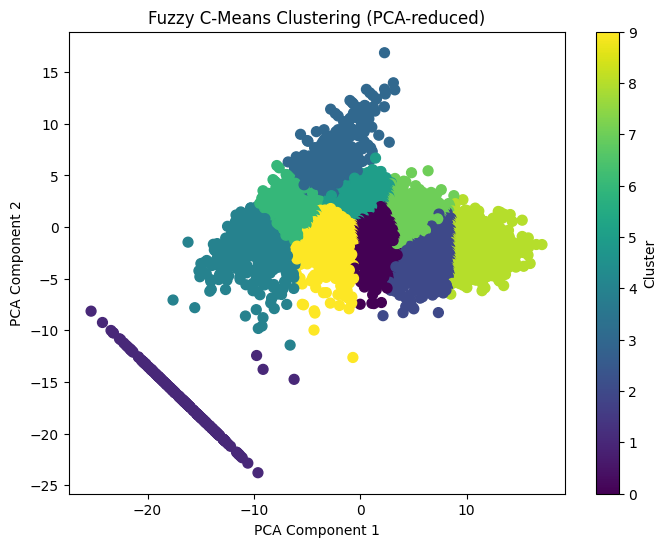

   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  cluster_0_membership  cluster_1_membership  cluster_2_membership  \
0   200630              0.023368              0.000531              0.115033   
1   793665              0.027393              0.000964          

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from fcmeans import FCM
from sklearn.decomposition import PCA

# Apply Fuzzy C-Means clustering
n_clusters = 10
fcm = FCM(n_clusters=n_clusters, m=1.5)  # Try lowering m (default is 2.0)
fcm.fit(cluster_df.values)

# Get the membership matrix
membership_matrix = fcm.u  # Shape: (n_samples, n_clusters)

# Convert membership matrix to DataFrame
membership_df = pd.DataFrame(membership_matrix, columns=[f'cluster_{i}_membership' for i in range(n_clusters)])

# Ensure index alignment before merging
membership_df.index = cluster_df.index  # Align indices before merging

# Merge membership scores into the original DataFrame
final_df = pd.concat([animes, membership_df], axis=1)

# Get the most dominant cluster for each anime
cluster_labels = membership_matrix.argmax(axis=1)

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cluster_df.values)

# Scatter plot with colors based on cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.title('Fuzzy C-Means Clustering (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Display the final DataFrame with anime info and clustering results
print(final_df.head())


Great! Okay, now we need to re-rank the SVD suggestions for a person based on the clusters

define the MMR based re-rank

In [145]:
# Global similarity cache
similarity_cache = {}

def cheeky_get_similarity(anime_id1, anime_id2, final_df, cluster_cols):
    """
    Get similarity between two anime with caching.
    """
    # Return 1.0 for same anime
    if anime_id1 == anime_id2:
        return 1.0
    
    # Check cache first (using sorted tuple as key for consistency)
    cache_key = tuple(sorted([anime_id1, anime_id2]))
    if cache_key in similarity_cache:
        return similarity_cache[cache_key]
    
    # Calculate similarity if not in cache
    anime1 = final_df[final_df['anime_id'] == anime_id1]
    anime2 = final_df[final_df['anime_id'] == anime_id2]
    
    # If either anime is not found, return 1 similarity
    if anime1.empty or anime2.empty:
        similarity_cache[cache_key] = 1
        print('anime empty')
        return 1
    
    # Create sets of cluster names where value is 1
    clusters1 = set()
    clusters2 = set()
    
    for col in cluster_cols:
        if anime1[col].values[0] == 1:
            clusters1.add(col)
        if anime2[col].values[0] == 1:
            clusters2.add(col)
    
    # Use enhanced_genre_similarity to calculate similarity
    similarity = enhanced_genre_similarity(clusters1, clusters2)
    
    # Cache the result
    similarity_cache[cache_key] = similarity
    return similarity

def get_similarity(anime_id1, anime_id2, final_df, cluster_cols):
    if anime_id1 == anime_id2:
        return 1.0
    
    # Check cache first (using sorted tuple as key for consistency)
    cache_key = tuple(sorted([anime_id1, anime_id2]))
    if cache_key in similarity_cache:
        return similarity_cache[cache_key]
    
    # Calculate similarity if not in cache
    anime1 = final_df[final_df['anime_id'] == anime_id1]
    anime2 = final_df[final_df['anime_id'] == anime_id2]
    
    # If either anime is not found, return 1 similarity
    if anime1.empty or anime2.empty:
        similarity_cache[cache_key] = 1
        print('anime empty')
        return 1
    
    # Extract cluster membership vectors
    vec1 = anime1[cluster_cols].values.flatten()
    vec2 = anime2[cluster_cols].values.flatten()
    
    # Calculate cosine similarity between cluster membership vectors
    # similarity = cosine_similarity([vec1], [vec2])[0][0]
    
    # Calculate Euclidean distance between cluster membership vectors
    from sklearn.metrics.pairwise import euclidean_distances
    distance = euclidean_distances([vec1], [vec2])[0][0]
    
    # Convert distance to similarity (closer to 0 distance means higher similarity)
    # Normalize to [0,1] range where 1 means identical
    max_possible_distance = np.sqrt(len(cluster_cols))  # Maximum possible distance
    similarity = 1 - (distance / max_possible_distance)


    # Cache the result
    similarity_cache[cache_key] = similarity
    return similarity


def mmr_rerank(user_id, svdpp, final_df, candidate_count=100, rerank_count=10, lambda_param=0.7):
    """
    Re-rank recommendations using Maximal Marginal Relevance algorithm.
    """
    # Get cluster columns once
    cluster_cols = [col for col in final_df.columns if 'cluster_' in col and '_membership' in col]
    
    # Step 1: Get initial predictions from SVD++
    all_anime_ids = final_df['anime_id'].unique().tolist()
    
    # Get predictions for all candidate anime
    predictions = []
    for anime_id in all_anime_ids:
        try:
            # Convert external ID to internal SVD++ ID
            inner_id = svdpp.trainset.to_inner_iid(int(anime_id))
            # Only proceed if conversion worked
            pred = svdpp.predict(user_id, int(anime_id)).est
            predictions.append((anime_id, pred))
        except (ValueError, KeyError):
            # Skip anime that aren't in the SVD++ model
            continue
    
    # Sort by prediction score and take top candidates
    candidates = sorted(predictions, key=lambda x: x[1], reverse=True)[:candidate_count]
    candidate_ids = [c[0] for c in candidates]
    
    # Step 2: Re-rank using MMR
    selected = []
    remaining = candidate_ids.copy()
    
    # Initialize with the highest predicted item
    if remaining:
        selected.append(remaining[0])
        remaining.remove(remaining[0])
    
    # Select the rest using MMR
    while len(selected) < rerank_count and remaining:
        max_mmr_score = -1
        max_mmr_item = None
        
        for item in remaining:
            # Calculate relevance (normalized prediction score)
            # Get all relevance scores for candidates
            relevance_scores = [candidates[i][1] for i in range(len(candidates))]
            min_score = min(relevance_scores)
            max_score = max(relevance_scores)
            
            # Normalize the relevance score in the MMR calculation
            relevance_idx = candidate_ids.index(item)
            raw_relevance = candidates[relevance_idx][1]
            # Avoid division by zero
            if max_score != min_score:
                relevance = (raw_relevance - min_score) / (max_score - min_score)
            else:
                print('all relevance scores identical?')
                relevance = .3  # If all scores are identical
            
            # Calculate diversity - min of the diversity scores out of all the items selected so far
            # diversity = 1
            # for selected_item in selected:
            #     sim = cheeky_get_similarity(item, selected_item, final_df, cluster_cols)
            #     diversity = min(diversity, 1-sim)
            
            # Calculate average diversity from all selected items instead of max or min
            sum_diversity = 0
            for selected_item in selected:
                sim = get_similarity(item, selected_item, final_df, cluster_cols)
                sum_diversity += (1-sim)
                        
            diversity = sum_diversity / len(selected) if selected else 0
            
            # Calculate MMR score
            mmr_score = lambda_param * relevance + (1 - lambda_param) * (diversity)
            
            # Update if this is the best MMR score so far
            if mmr_score > max_mmr_score:
                max_mmr_score = mmr_score
                max_mmr_item = item
        
        # Add the item with the highest MMR score
        if max_mmr_item:
            selected.append(max_mmr_item)
            remaining.remove(max_mmr_item)
    
    return selected

def get_recommendations_with_mmr(test_users, svdpp, final_df, n=5, lambda_param=0.7):
    """
    Get recommendations with MMR re-ranking and diversity metrics.
    """
    # Initialize caches if not already done
    if not anime_genres:
        initialize_caches(final_df)
    
    # Results arrays
    diversity_scores = []
    genre_diversity_scores = []
    latent_diversity_scores = []
    long_tail_penalty_scores = []
    predictions = []
    
    total_users = len(test_users)
    print(f"Processing {total_users} users with MMR re-ranking (lambda={lambda_param})...")
    
    # Process each user
    for i, (_, u) in enumerate(test_users.iterrows()):
        uid = int(u["user_id"])
        
        # Print progress
        if i % 10 == 0 or i / total_users in [0.25, 0.5, 0.75, 0.99]:
            percentage = (i / total_users) * 100
            print(f"Progress: {percentage:.1f}% ({i}/{total_users} users processed)")
            print(f"Similarity cache size: {len(similarity_cache)} pairs")
        
        # Get MMR re-ranked recommendations
        top_n_anime = mmr_rerank(uid, svdpp, final_df, 
                                 candidate_count=100, 
                                 rerank_count=n, 
                                 lambda_param=lambda_param)
        
        if not top_n_anime:
            print(f"User {uid}: No recommendations found, skipping")
            continue
        
        # Add to predictions list
        predictions.append({uid: top_n_anime})
        
        # Calculate diversity scores
        scores = calculate_diversity(top_n_anime, svdpp)
        
        # Store results
        diversity_scores.append(scores[0])
        genre_diversity_scores.append(scores[1])
        latent_diversity_scores.append(scores[2])
        long_tail_penalty_scores.append(scores[3])
    
    print(f"Completed processing all {total_users} users")
    print(f"Final similarity cache size: {len(similarity_cache)} pairs")
    
    # Calculate average metrics
    avg_diversity = sum(diversity_scores) / len(diversity_scores) if diversity_scores else 0
    print(f"Average diversity score: {avg_diversity:.4f}")
    
    return diversity_scores, genre_diversity_scores, latent_diversity_scores, long_tail_penalty_scores, predictions

In [146]:
custom_agg_scores, custom_genre_scores, custom_latent_scores, custom_penalty_scores, custom_predictions = get_recommendations_with_mmr(
    test_users[:100], svdpp, final_df, n=20, lambda_param=0.3)

Processing 100 users with MMR re-ranking (lambda=0.3)...
Progress: 0.0% (0/100 users processed)
Similarity cache size: 0 pairs
Progress: 10.0% (10/100 users processed)
Similarity cache size: 9559 pairs
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical?
all relevance scores identical

In [149]:
def compute_diversity_scores(predictions, svdpp):
    diversity_scores = []
    genre_diversity_scores = []
    latent_diversity_scores = []
    long_tail_penalty_scores = []

    for i, prediction in enumerate(predictions):
        for uid, top_n_anime in prediction.items():
            scores = calculate_diversity(top_n_anime, svdpp)
            # Store results
            diversity_scores.append(scores[0])
            genre_diversity_scores.append(scores[1])
            latent_diversity_scores.append(scores[2])
            long_tail_penalty_scores.append(scores[3])
        
        # Print progress every 10 predictions
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1} predictions...")

    return diversity_scores, genre_diversity_scores, latent_diversity_scores, long_tail_penalty_scores

In [159]:
custom_agg_scores, custom_genre_scores, custom_latent_scores, custom_penalty_scores = compute_diversity_scores(custom_predictions, svdpp)

In [81]:
def plot_diversity_scores2(diversity_scores, genre_scores, latent_scores, penalty_scores, user_ids=None):
    """
    Plot diversity metrics across multiple users or recommendation sets.
    
    Args:
        diversity_scores: List of aggregate diversity scores
        genre_scores: List of genre diversity scores
        latent_scores: List of latent diversity scores
        penalty_scores: List of popularity penalty scores
        user_ids: Optional list of user IDs or labels (defaults to indices)
    """
    # Create x-axis labels (user IDs or indices)
    x_labels = user_ids if user_ids else range(len(diversity_scores))
    x_pos = np.arange(len(x_labels))
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot each metric as a separate line
    plt.plot(x_pos, diversity_scores, 'b-', label='Aggregate Diversity', linewidth=2, marker='o')
    plt.plot(x_pos, genre_scores, 'g-', label='Genre Diversity', linewidth=2, marker='s')
    plt.plot(x_pos, latent_scores, 'r-', label='Latent Diversity', linewidth=2, marker='^')
    plt.plot(x_pos, penalty_scores, 'y-', label='Popularity Penalty', linewidth=2, marker='x')
    
    # Add statistics
    avg_div = sum(diversity_scores) / len(diversity_scores)
    plt.axhline(y=avg_div, color='b', linestyle='--', alpha=0.7, 
                label=f'Avg Aggregate: {avg_div:.2f}')
    
    # Configure plot
    plt.xlabel('User ID' if user_ids else 'User Index')
    plt.ylabel('Diversity Score')
    plt.title('Recommendation Diversity Metrics by User')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Handle x-axis ticks for readability
    if len(x_labels) > 10:
        plt.xticks(x_pos[::5], x_labels[::5])  # Show every 5th label
    else:
        plt.xticks(x_pos, x_labels)
        
    plt.tight_layout()
    plt.savefig('custom_diversity_scores.png')
    plt.show()

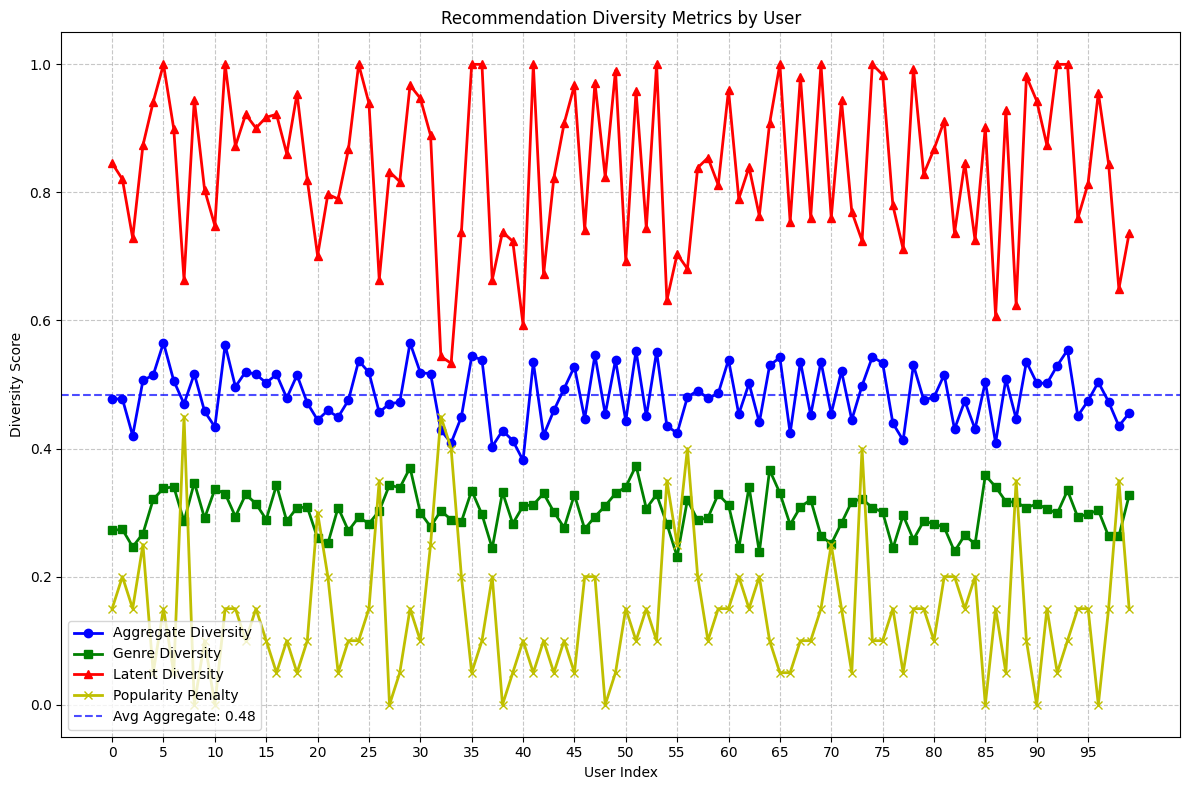

In [160]:
plot_diversity_scores2(custom_agg_scores,custom_genre_scores,custom_latent_scores,custom_penalty_scores)

In [67]:
print(custom_predictions[:5])

[{1831: [9969, 24701, 32935, 9253, 1535, 2904, 1575, 4181, 16498, 372, 32281, 28977, 15417, 11061, 5114, 2001, 1, 23273, 19, 457]}, {1873: [9969, 24701, 32935, 9253, 1535, 2904, 1575, 4181, 16498, 30276, 199, 2001, 1, 44, 19, 457, 164, 28891, 431, 263]}, {4177: [9969, 24701, 32935, 9253, 1535, 2904, 1575, 4181, 16498, 30276, 199, 2001, 1, 44, 19, 19815, 457, 7311, 164, 28891]}, {3668: [4059, 25013, 14713, 790, 28249, 8086, 3228, 3470, 7647, 13331, 2890, 15315, 9656, 30015, 57, 9617, 31478, 114, 4280, 8525]}, {4796: [5114, 28977, 15417, 32281, 9253, 1535, 9969, 24701, 2904, 1575, 16498, 2001, 1, 23273, 19, 19815, 6547, 457, 7311, 164]}]


In [68]:
def jaccard_similarity2(list1, list2):
    """
    Calculate the average Jaccard similarity between two lists of dictionaries.
    
    Arguments:
    - list1: First list of dictionaries with {key: [predictions]} format.
    - list2: Second list of dictionaries with {key: [predictions]} format.
    
    Returns:
    - Average Jaccard similarity.
    """
    def jaccard_index(set1, set2):
        """
        Calculate the Jaccard index between two sets.
        """
        intersection = set1.intersection(set2)
        union = set1.union(set2)
        return len(intersection) / len(union)
    
    # Initialize a variable to keep track of the total Jaccard similarity
    total_similarity = 0
    num_keys = 0
    
    # Iterate through each dictionary in both lists
    for dict1, dict2 in zip(list1, list2):
        # Iterate through each key-value pair in the dictionaries
        for key in dict1:
            # If the key is also present in the second dictionary, calculate Jaccard similarity
            if key in dict2:
                set1 = set(dict1[key])
                set2 = set(dict2[key])
                total_similarity += jaccard_index(set1, set2)
                num_keys += 1
    
    # Return the average Jaccard similarity
    if num_keys == 0:
        return 0
    return total_similarity / num_keys

In [70]:
jaccard_similarity2(predictions, custom_predictions)

0.2601933772834014

plot results

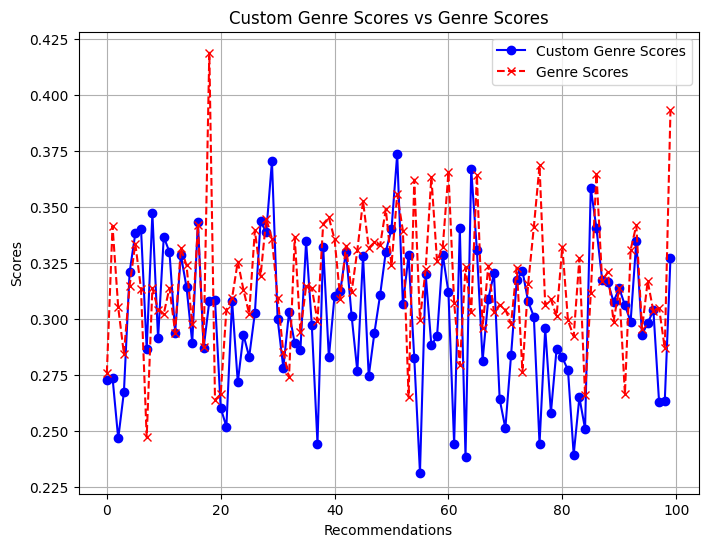

In [168]:
def plot_genre_scores(custom_genre_scores, genre_scores):
    
    # Check if the lengths of the lists are the same
    if len(custom_genre_scores) != len(genre_scores):
        raise ValueError("The lists custom_genre_scores and genre_scores must have the same length.")
    
    # Create x-values as indices (or genre labels if available)
    x_values = range(len(custom_genre_scores))
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    
    # Plot custom_genre_scores
    plt.plot(x_values, custom_genre_scores, marker='o', linestyle='-', color='b', label='Custom Genre Scores')
    
    # Plot genre_scores
    plt.plot(x_values, genre_scores, marker='x', linestyle='--', color='r', label='Genre Scores')
    
    # Adding labels and title
    plt.xlabel('Recommendations')
    plt.ylabel('Scores')
    plt.title('Custom Genre Scores vs Genre Scores')
    
    # Show legend
    plt.legend()
    
    # Display the plot
    plt.grid(True)
    plt.savefig('genre_score_comparison.png')
    plt.show()
    
plot_genre_scores(custom_genre_scores, genre_scores)

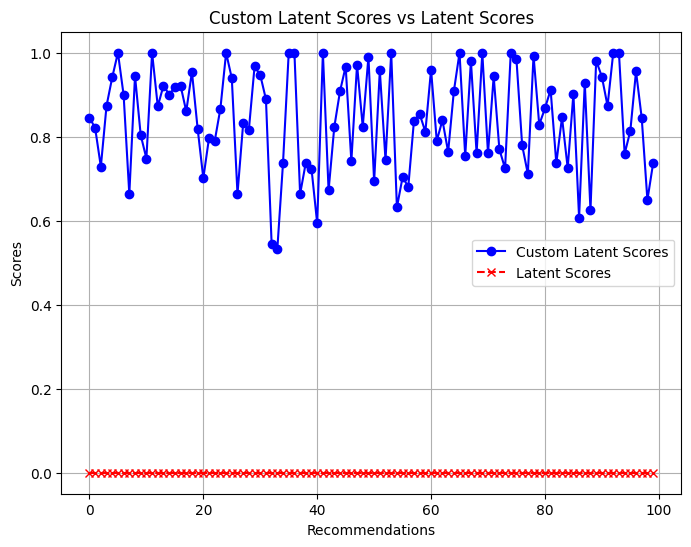

In [164]:
def plot_latent_scores(custom_latent_scores, latent_scores):
    """
    Plots custom_latent_scores vs latent_scores on the same figure.
    
    Arguments:
    custom_latent_scores -- A list or array of custom latent scores
    latent_scores -- A list or array of latent scores
    
    The function plots the values of custom_latent_scores and latent_scores as y-values 
    and their respective indices as x-values.
    """
    
    # Check if the lengths of the lists are the same
    if len(custom_latent_scores) != len(latent_scores):
        raise ValueError("The lists custom_latent_scores and latent_scores must have the same length.")
    
    # Create x-values as indices (or genre labels if available)
    x_values = range(len(custom_latent_scores))
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    
    # Plot custom_latent_scores
    plt.plot(x_values, custom_latent_scores, marker='o', linestyle='-', color='b', label='Custom Latent Scores')
    
    # Plot latent_scores
    plt.plot(x_values, latent_scores, marker='x', linestyle='--', color='r', label='Latent Scores')
    
    # Adding labels and title
    plt.xlabel('Recommendations')
    plt.ylabel('Scores')
    plt.title('Custom Latent Scores vs Latent Scores')
    
    # Show legend
    plt.legend()
    
    # Display the plot
    plt.grid(True)
    plt.savefig('latent_score_comparison.png')

    plt.show()

plot_latent_scores(custom_latent_scores, latent_scores)


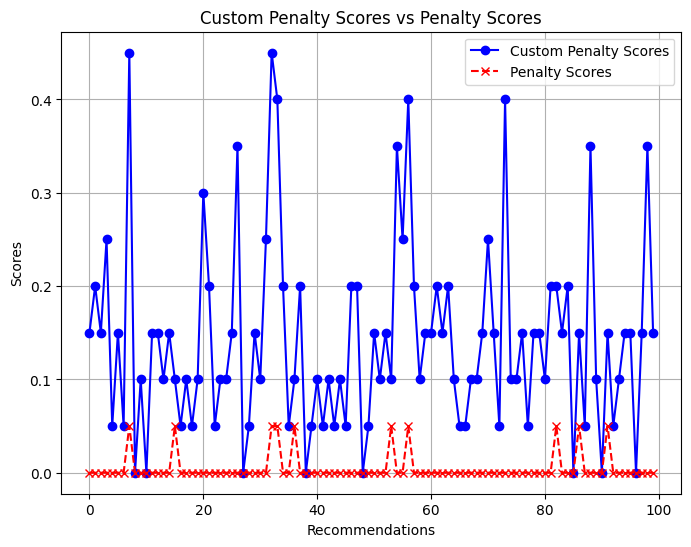

In [165]:
def plot_penalty_scores(custom_penalty_scores, penalty_scores):
    """
    Plots custom_penalty_scores vs penalty_scores on the same figure.
    
    Arguments:
    custom_penalty_scores -- A list or array of custom penalty scores
    penalty_scores -- A list or array of penalty scores
    
    The function plots the values of custom_penalty_scores and penalty_scores as y-values 
    and their respective indices as x-values.
    """
    
    # Check if the lengths of the lists are the same
    if len(custom_penalty_scores) != len(penalty_scores):
        raise ValueError("The lists custom_penalty_scores and penalty_scores must have the same length.")
    
    # Create x-values as indices (or genre labels if available)
    x_values = range(len(custom_penalty_scores))
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    
    # Plot custom_penalty_scores
    plt.plot(x_values, custom_penalty_scores, marker='o', linestyle='-', color='b', label='Custom Penalty Scores')
    
    # Plot penalty_scores
    plt.plot(x_values, penalty_scores, marker='x', linestyle='--', color='r', label='Penalty Scores')
    
    # Adding labels and title
    plt.xlabel('Recommendations')
    plt.ylabel('Scores')
    plt.title('Custom Penalty Scores vs Penalty Scores')
    
    # Show legend
    plt.legend()
    
    # Display the plot
    plt.grid(True)
    plt.savefig('penalty_score_comparison.png')

    plt.show()

plot_penalty_scores(custom_penalty_scores, penalty_scores)


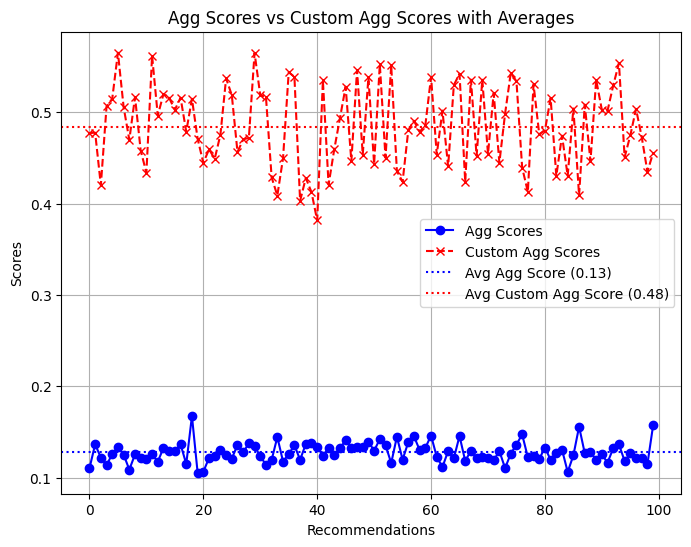

In [167]:
def plot_agg_scores_with_average(agg_scores, custom_agg_scores):
    """
    Plots agg_scores vs custom_agg_scores with averages on the same figure.
    
    Arguments:
    agg_scores -- A list or array of aggregated scores
    custom_agg_scores -- A list or array of custom aggregated scores
    
    The function plots the values of agg_scores and custom_agg_scores as y-values 
    and their respective indices as x-values. It also plots the average for each.
    """
    
    # Check if the lengths of the lists are the same
    if len(agg_scores) != len(custom_agg_scores):
        raise ValueError("The lists agg_scores and custom_agg_scores must have the same length.")
    
    # Create x-values as indices (or genre labels if available)
    x_values = range(len(agg_scores))
    
    # Calculate averages
    avg_agg_score = sum(agg_scores) / len(agg_scores)
    avg_custom_agg_score = sum(custom_agg_scores) / len(custom_agg_scores)
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    
    # Plot agg_scores
    plt.plot(x_values, agg_scores, marker='o', linestyle='-', color='b', label='Agg Scores')
    
    # Plot custom_agg_scores
    plt.plot(x_values, custom_agg_scores, marker='x', linestyle='--', color='r', label='Custom Agg Scores')
    
    # Plot averages
    plt.axhline(y=avg_agg_score, color='b', linestyle=':', label=f'Avg Agg Score ({avg_agg_score:.2f})')
    plt.axhline(y=avg_custom_agg_score, color='r', linestyle=':', label=f'Avg Custom Agg Score ({avg_custom_agg_score:.2f})')
    
    # Adding labels and title
    plt.xlabel('Recommendations')
    plt.ylabel('Scores')
    plt.title('Agg Scores vs Custom Agg Scores with Averages')
    
    # Show legend
    plt.legend()
    
    # Display the plot
    plt.grid(True)
    plt.savefig('agg_score_comparison_with_avg.png')

    plt.show()


plot_agg_scores_with_average(agg_scores, custom_agg_scores)
